# Dermatologist-AI Project: Dual Network Approach
Workbook for a dual network approach. Tensors will be fed into two identical model architectures, one trained to distinguish melanomas vs. others, and one trained to distinguish SBKs vs. others. The results will be aggregated into a single prediction.csv file



Import image files

In [1]:
import numpy as np
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
import pickle

#define dataset import function
def load_dataset(path, shuffle):
    data = load_files(path, shuffle=shuffle)
    file_paths = np.array(data['filenames'])
    one_hot_labels = np_utils.to_categorical(np.array(data['target']),3)
    return file_paths, one_hot_labels

#import datasets
train_files, train_labels = load_dataset('../data/train', True)
valid_files, valid_labels = load_dataset('../data/valid', True)
test_files, test_labels = load_dataset('../data/test', False)

# load list of skin condition names
skin_names = [item[14:-1] for item in sorted(glob("../data/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(skin_names))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

Using TensorFlow backend.


There are 3 total categories.
There are 2750 total images.

There are 2000 training images.
There are 150 validation images.
There are 600 test images.


## Let's first understand the dataset
Various simple analysis to understand types of pictures

In [2]:
import pandas as pd

train_data = pd.DataFrame(train_labels)
valid_data = pd.DataFrame(valid_labels)
test_data = pd.DataFrame(test_labels)

print(train_data.sum(axis=0))
print(valid_data.sum(axis=0))
print(test_data.sum(axis=0))



0     374.0
1    1372.0
2     254.0
dtype: float64
0    30.0
1    78.0
2    42.0
dtype: float64
0    117.0
1    393.0
2     90.0
dtype: float64


Convert images into 4D tensors

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

img_width = 224
img_height = 224

#define image processing functions (from udacity dog project)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)   

In [4]:
# Pre-process the data for Keras
# Skip if we already have pickled files

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:42<00:00,  9.55it/s]


In [5]:
# Pickle tensors to pick up where I left off in future
# Skip if we already have pickled files

with open('train_tensors.pickle', 'wb') as handle:
    pickle.dump(train_tensors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('valid_tensors.pickle', 'wb') as handle:
    pickle.dump(valid_tensors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_tensors.pickle', 'wb') as handle:
    pickle.dump(test_tensors, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# Un-pickle tensors
with open('train_tensors.pickle', 'rb') as handle:
    train_tensors = pickle.load(handle)
    
with open('valid_tensors.pickle', 'rb') as handle:
    valid_tensors = pickle.load(handle)

with open('test_tensors.pickle', 'rb') as handle:
    test_tensors = pickle.load(handle)

Create a new network based on first 2 blocks of VGGNet, plus 1 trainable convolutional block, followed by fully connected layer

In [20]:
from keras import applications
from keras.models import Sequential, Model 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense

network = Sequential()

#First 4 blocks of VGG19
network.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv1', 
                        input_shape=(224, 224, 3)))
network.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv2'))
network.add(MaxPooling2D(pool_size=2, name='block1_pool'))
network.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv1'))
network.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv2'))
network.add(MaxPooling2D(pool_size=2, name='block2_pool'))
network.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv1'))
network.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv2'))
network.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv3'))
network.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv4'))
network.add(MaxPooling2D(pool_size=2, name='block3_pool'))
network.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv1'))
network.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv2'))
network.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv3'))
network.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv4'))
network.add(MaxPooling2D(pool_size=2, name='block4_pool'))

#First 1 trainable convnet block
network.add(Dropout(0.5))
network.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv1'))
network.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv2'))
network.add(MaxPooling2D(pool_size=2, name='block5_pool'))
network.add(Dropout(0.5))

#Trainable dense layers
network.add(Flatten())
network.add(Dense(4096, activation='relu'))
network.add(Dropout(0.5))
network.add(Dense(4096, activation='relu'))
network.add(Dropout(0.5))
network.add(Dense(3, activation='softmax'))

network.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

Download VGG19 weights and set for VGGnet layers

In [21]:
import h5py
weights_path = 'vgg19_weights.h5'#'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
f = h5py.File(weights_path, 'r')

VGGnet_layers = ['block1_conv1',
                 'block1_conv2',
                 'block2_conv1',
                 'block2_conv2',
                 'block3_conv1',
                 'block3_conv2',
                 'block3_conv3',
                 'block3_conv4',
                 'block4_conv1',
                 'block4_conv2',
                 'block4_conv3',
                 'block4_conv4']]
layer_names = [layer.name for layer in network.layers]

for i in VGGnet_layers:
    weight_names = f[i].attrs["weight_names"]
    weights = [f[i][j] for j in weight_names]    
    index = layer_names.index(i)
    network.layers[index].set_weights(weights)


In [22]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.00005, decay=1e-6)
network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Set up image augmentation generator and trainer

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=30, # randomly rotate images up to 30 degrees
    zoom_range=0.2, # randomly zoom in and out by 10%
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=30, # randomly rotate images up to 30 degrees
    zoom_range=0.2, # randomly zoom in and out by 10%
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)



In [24]:
# Create callback to print recall and precision during training
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        _val_recall = recall_score(val_targ, val_predict, average='weighted')
        _val_precision = precision_score(val_targ, val_predict, average='weighted')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print("val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()

In [ ]:
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/best.weights.hdf5', 
                               verbose=1, save_best_only=True)

network.fit_generator(datagen_train.flow(train_tensors, train_labels, batch_size=20),
                    steps_per_epoch=train_tensors.shape[0] // 20,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_labels, batch_size=20),
                    validation_steps=valid_tensors.shape[0] // 20)

Epoch 1/20


## Create output excel

In [10]:
# Load the model weights with the best validation loss.

network.load_weights('saved_models/best.weights.hdf5')

In [15]:
import pandas as pd

y_pred = pd.DataFrame(columns=["task_1", "task_2"])

for ii in tqdm(range(len(test_files))):
    path = test_files[ii]
    prediction = np.argmax(network.predict(np.expand_dims(test_tensors[ii], axis=0)))
    if prediction == 0:
        y_pred.loc[path] = [1, 0]
    if prediction == 2:
        y_pred.loc[path] = [0, 1]
    else:
        y_pred.loc[path] = [0, 0]

y_pred.to_csv("predictions.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:10<00:00,  4.55it/s]


## Code playground to be deleted later

In [16]:
import itertools
import keras
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

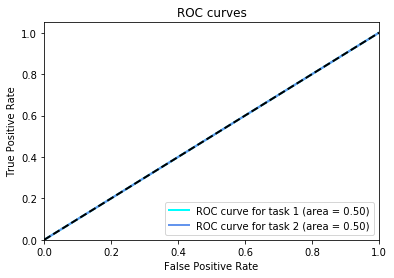

Category 1 Score: 0.500
Category 2 Score: 0.500
Category 3 Score: 0.500


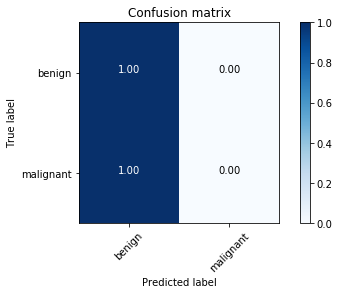

In [19]:
preds_path = sys.argv[1]
thresh = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv("predictions.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
